In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_03 import *

## DataBunch/Learner

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 64
c = y_train.max().item()+1
loss_func = F.cross_entropy

Factor out the connected pieces of info out of the fit() argument list

`fit(epochs, model, loss_func, opt, train_dl, valid_dl)`

Let's replace it with something that looks like this:

`fit(1, learn)`

This will allow us to tweak what's happening inside the training loop in other places of the code because the `Learner` object will be mutable, so changing any of its attribute elsewhere will be seen in our training loop.

In [4]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
        
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset      

In [27]:
len(train_ds)//bs, len(valid_ds)//bs

(781, 156)

In [5]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [6]:
get_dls??

In [7]:
data.train_ds.x.shape

torch.Size([50000, 784])

In [8]:
data.valid_ds.x.shape

torch.Size([10000, 784])

In [9]:
#export
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data   

In [10]:
learn = Learner(*get_model(data), loss_func, data)

In [11]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv    

In [12]:
loss, acc = fit(1, learn)

0 tensor(0.2936) tensor(0.9110)


## CallbackHandler

### What are callbacks and why do we need them?  
While the above training loops works perfectly, there are probably going to be times when we want to customize it. There are many different things we might want to do, e.g.:
- Print out some custom metrics during the training
- Alter the learning rate throughout the training
- Switch our training between different models (e.g. in a GAN architecture)    
Callbacks allow us to do these types of things. Essentially, a callback is an item that inserts custom code into the training loop at different times.

### How can we create callbacks?
There are three main steps to creating callbacks in our training loop:
- Create some callback objects
- Create a CallbackHandler (an object where we will store our callback objects)
- Incorporate the callbacks into our training loop

In [13]:
# generic callback class
class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch = epoch
        return True
    def after_epoch(self): return True
    def begin_validate(self): return True
    def begin_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

### Why do we need a generic callback class?
You may have noticed that when we wrote the callbacks, we inherited from a generic callback class. This is to make sure that every callback object has a function defined for every different point in time (begin_fit, after_fit, begin_epoch, etc.). If these functions aren’t all defined, then we will get an exception when the training loop runs, because it looks for each of these functions

In [14]:
import time
# Step 1: crete some callback objects
# prints the number of ITERATIONS(Batches) upto 10 and then stops training.
class TestCallback(Callback):
    def begin_fit(self, learn):
        super().begin_fit(learn)
        self.n_iters = 0 
        return True
    
    # after_step=True zeros out the gradients
    def after_step(self):
        self.n_iters += 1
        print(self.n_iters)
        if self.n_iters>=10: self.learn.stop = True
        return True

#prints the time at which an epoch starts
#Every time we begin an epoch, we will call begin_epoch,
#which will keep track of which epoch we are on, and 
#print out the epoch number and the current time
class Timecheck(Callback):
    # when we begin training, we will call begin_fit, which will set epoch_counter to 1.
    def begin_fit(self, learn):
        self.learn = learn
        self.epoch_counter = 1
        return True
    
    def begin_epoch(self, epoch):
        self.epoch = epoch
        print(f'Epoch {self.epoch_counter} started at {time.strftime("%H:%M:%S", time.gmtime())}')
        self.epoch_counter += 1
        return True
    
# Every time we complete an epoch, we will call 
# after_epoch, which will print out the most recent loss
# calculation.
class PrintLoss(Callback):
    def after_epoch(self):
        print(f'Loss:{self.loss}')
        return True            

In [15]:
# Step 2: create a callback Handler
class CallbackHandler():
    def __init__(self, cbs=None):
        self.cbs = cbs if cbs else []
    
    def begin_fit(self, learn):
        self.learn = learn
        self.in_train = True
        learn.stop = False
        res = True
        for cb in self.cbs: res=res and cb.begin_fit(learn)
        return res
    
    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res=res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train = True
        res = True
        for cb in self.cbs: res=res and cb.begin_epoch(epoch)
        return res
    
    def begin_validate(self):
        self.learn.model.eval()
        self.in_train = False
        res = True
        for cb in self.cbs: res=res and cb.begin_validate()
        return res
    
    def after_epoch(self):
        res = True
        for cb in self.cbs: res=res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res=res and cb.begin_batch(xb, yb)
        return res
    
    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res=res and cb.after_loss(loss)
        return res
    
    def after_backward(self):
        res= True
        for cb in self.cbs: res=res and cb.after_backward()
        return res
    
    def after_step(self):
        res = True
        for cb in self.cbs: res=res and cb.after_step()
        return res
    
    def do_stop(self):
        try: return self.learn.stop
        finally: self.learn.stop = False

The CallbackHandler class serves two main purposes:
- It gives us a place to store all of our individual callbacks. In the above code, the individual callbacks are stored in a list named self.cbs (this happens in the “__init__” function)
- It allows us to easily call all of our individual callbacks at the same time. For each different point in time in the training loop, we create a function (begin_fit, after_fit, begin_epoch, etc.). When we call one of these functions, it goes through all our individual callbacks (TestCallback, TimeCheck, PrintLoss) and calls its same-named function. You’ll notice that these functions don’t exist solely to call the callbacks, e.g. begin_epoch also calls learn.model.train(), but that’s not too important to understand for now  
  
Here’s a diagram summarizing what we have created so far:
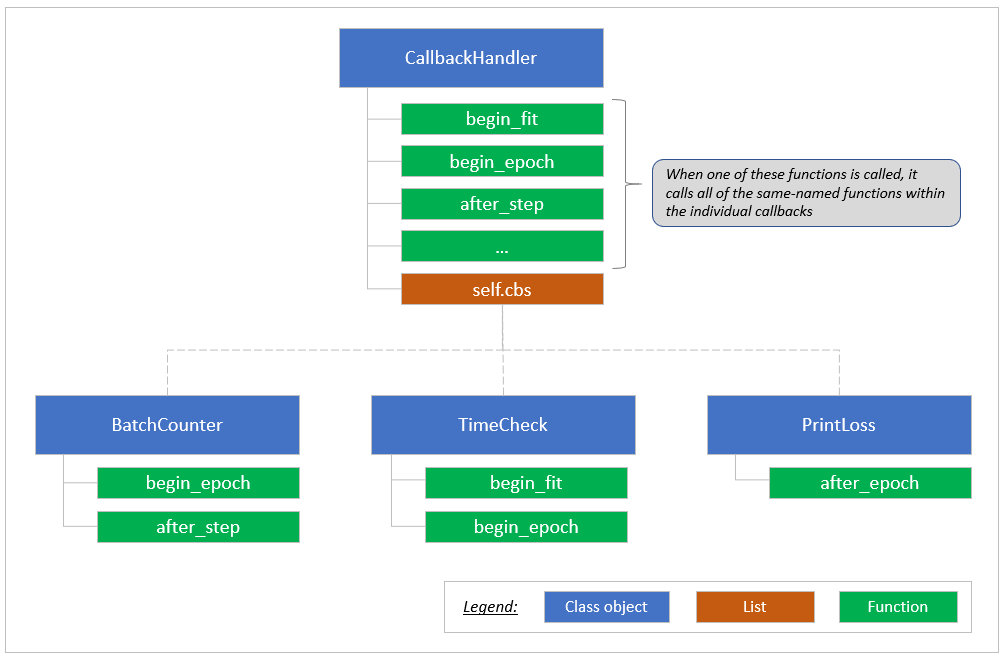
Also the TestCallback function

Every time the begin_fit() function is called on CallbackHandler() it loops through the list of callbacks (cbs) and for each callback(cb) if runs the begin_fit function inside that callback class.   
__Remember, that in the case where there is no begin_fit function in that particular callback class, it will run on the original Callback() template class we discussed at point 1.__

This was our training loop (without validation) from the previous notebook, with the inner loop contents factored out:

```python
def one_batch(xb,yb):
    pred = model(xb)
    loss = loss_func(pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
def fit():
    for epoch in range(epochs):
        for b in train_dl: one_batch(*b)
```

Add callbacks so we can remove complexity from loop, and make it flexible:

In [28]:
# Step 3: Incorporate the callbacks into our training loop
def one_batch(xb, yb, cb):
    if not cb.begin_batch(xb, yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()
#     print(f"A{cb.learn.stop}")
        
def all_batches(dl, cb):
    for xb,yb in dl:
        one_batch(xb,yb, cb)
#         print(f"B{cb.learn.stop}")
#         print(f"do_stop:{cb.do_stop()}")
        if cb.do_stop(): return
    
def fit(epochs, learn, cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch): continue
        all_batches(learn.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
#         print(cb.learn.stop)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()             

You may have noticed that there are a lot of if statements in the updated code. This gives us the ability to stop the training at any time we want (or skip specific steps). For example, if we only wanted to train for 20 batches, we could create a callback that returns False after the 20th batch is complete.

In [19]:
fit(5, learn, cb=CallbackHandler([Timecheck(), PrintLoss()]))

Epoch 1 started at 12:54:06
Loss:0.006560278125107288
Epoch 2 started at 12:54:07
Loss:0.002138900337740779
Epoch 3 started at 12:54:09
Loss:0.011787118390202522
Epoch 4 started at 12:54:10
Loss:0.004337035119533539
Epoch 5 started at 12:54:11
Loss:0.005933812819421291


In [20]:
fit(1, learn, cb=CallbackHandler([TestCallback()]))

1
2
3
4
5
6
7
8
9
10


In [23]:
fit(5, learn, cb=CallbackHandler([Timecheck(), PrintLoss(), TestCallback()]))

Epoch 1 started at 12:56:02
1
AFalse
BFalse
do_stop:False
2
AFalse
BFalse
do_stop:False
3
AFalse
BFalse
do_stop:False
4
AFalse
BFalse
do_stop:False
5
AFalse
BFalse
do_stop:False
6
AFalse
BFalse
do_stop:False
7
AFalse
BFalse
do_stop:False
8
AFalse
BFalse
do_stop:False
9
AFalse
BFalse
do_stop:False
10
ATrue
BTrue
do_stop:True
11
ATrue
BTrue
do_stop:True
12
ATrue
BTrue
do_stop:True
13
ATrue
BTrue
do_stop:True
14
ATrue
BTrue
do_stop:True
15
ATrue
BTrue
do_stop:True
16
ATrue
BTrue
do_stop:True
17
ATrue
BTrue
do_stop:True
18
ATrue
BTrue
do_stop:True
19
ATrue
BTrue
do_stop:True
20
ATrue
BTrue
do_stop:True
21
ATrue
BTrue
do_stop:True
22
ATrue
BTrue
do_stop:True
23
ATrue
BTrue
do_stop:True
24
ATrue
BTrue
do_stop:True
25
ATrue
BTrue
do_stop:True
26
ATrue
BTrue
do_stop:True
27
ATrue
BTrue
do_stop:True
28
ATrue
BTrue
do_stop:True
29
ATrue
BTrue
do_stop:True
30
ATrue
BTrue
do_stop:True
31
ATrue
BTrue
do_stop:True
32
ATrue
BTrue
do_stop:True
33
ATrue
BTrue
do_stop:True
34
ATrue
BTrue
do_stop:True
35

ATrue
BTrue
do_stop:True
345
ATrue
BTrue
do_stop:True
346
ATrue
BTrue
do_stop:True
347
ATrue
BTrue
do_stop:True
348
ATrue
BTrue
do_stop:True
349
ATrue
BTrue
do_stop:True
350
ATrue
BTrue
do_stop:True
351
ATrue
BTrue
do_stop:True
352
ATrue
BTrue
do_stop:True
353
ATrue
BTrue
do_stop:True
354
ATrue
BTrue
do_stop:True
355
ATrue
BTrue
do_stop:True
356
ATrue
BTrue
do_stop:True
357
ATrue
BTrue
do_stop:True
358
ATrue
BTrue
do_stop:True
359
ATrue
BTrue
do_stop:True
360
ATrue
BTrue
do_stop:True
361
ATrue
BTrue
do_stop:True
362
ATrue
BTrue
do_stop:True
363
ATrue
BTrue
do_stop:True
364
ATrue
BTrue
do_stop:True
365
ATrue
BTrue
do_stop:True
366
ATrue
BTrue
do_stop:True
367
ATrue
BTrue
do_stop:True
368
ATrue
BTrue
do_stop:True
369
ATrue
BTrue
do_stop:True
370
ATrue
BTrue
do_stop:True
371
ATrue
BTrue
do_stop:True
372
ATrue
BTrue
do_stop:True
373
ATrue
BTrue
do_stop:True
374
ATrue
BTrue
do_stop:True
375
ATrue
BTrue
do_stop:True
376
ATrue
BTrue
do_stop:True
377
ATrue
BTrue
do_stop:True
378
ATrue
BTrue
do

686
ATrue
BTrue
do_stop:True
687
ATrue
BTrue
do_stop:True
688
ATrue
BTrue
do_stop:True
689
ATrue
BTrue
do_stop:True
690
ATrue
BTrue
do_stop:True
691
ATrue
BTrue
do_stop:True
692
ATrue
BTrue
do_stop:True
693
ATrue
BTrue
do_stop:True
694
ATrue
BTrue
do_stop:True
695
ATrue
BTrue
do_stop:True
696
ATrue
BTrue
do_stop:True
697
ATrue
BTrue
do_stop:True
698
ATrue
BTrue
do_stop:True
699
ATrue
BTrue
do_stop:True
700
ATrue
BTrue
do_stop:True
701
ATrue
BTrue
do_stop:True
702
ATrue
BTrue
do_stop:True
703
ATrue
BTrue
do_stop:True
704
ATrue
BTrue
do_stop:True
705
ATrue
BTrue
do_stop:True
706
ATrue
BTrue
do_stop:True
707
ATrue
BTrue
do_stop:True
708
ATrue
BTrue
do_stop:True
709
ATrue
BTrue
do_stop:True
710
ATrue
BTrue
do_stop:True
711
ATrue
BTrue
do_stop:True
712
ATrue
BTrue
do_stop:True
713
ATrue
BTrue
do_stop:True
714
ATrue
BTrue
do_stop:True
715
ATrue
BTrue
do_stop:True
716
ATrue
BTrue
do_stop:True
717
ATrue
BTrue
do_stop:True
718
ATrue
BTrue
do_stop:True
719
ATrue
BTrue
do_stop:True
720
ATrue
BTru

BTrue
do_stop:True
863
ATrue
BTrue
do_stop:True
864
ATrue
BTrue
do_stop:True
865
ATrue
BTrue
do_stop:True
866
ATrue
BTrue
do_stop:True
867
ATrue
BTrue
do_stop:True
868
ATrue
BTrue
do_stop:True
869
ATrue
BTrue
do_stop:True
870
ATrue
BTrue
do_stop:True
871
ATrue
BTrue
do_stop:True
872
ATrue
BTrue
do_stop:True
873
ATrue
BTrue
do_stop:True
874
ATrue
BTrue
do_stop:True
875
ATrue
BTrue
do_stop:True
876
ATrue
BTrue
do_stop:True
877
ATrue
BTrue
do_stop:True
878
ATrue
BTrue
do_stop:True
879
ATrue
BTrue
do_stop:True
880
ATrue
BTrue
do_stop:True
881
ATrue
BTrue
do_stop:True
882
ATrue
BTrue
do_stop:True
883
ATrue
BTrue
do_stop:True
884
ATrue
BTrue
do_stop:True
885
ATrue
BTrue
do_stop:True
886
ATrue
BTrue
do_stop:True
887
ATrue
BTrue
do_stop:True
888
ATrue
BTrue
do_stop:True
889
ATrue
BTrue
do_stop:True
890
ATrue
BTrue
do_stop:True
891
ATrue
BTrue
do_stop:True
892
ATrue
BTrue
do_stop:True
893
ATrue
BTrue
do_stop:True
894
ATrue
BTrue
do_stop:True
895
ATrue
BTrue
do_stop:True
896
ATrue
BTrue
do_stop:

1141
ATrue
BTrue
do_stop:True
1142
ATrue
BTrue
do_stop:True
1143
ATrue
BTrue
do_stop:True
1144
ATrue
BTrue
do_stop:True
1145
ATrue
BTrue
do_stop:True
1146
ATrue
BTrue
do_stop:True
1147
ATrue
BTrue
do_stop:True
1148
ATrue
BTrue
do_stop:True
1149
ATrue
BTrue
do_stop:True
1150
ATrue
BTrue
do_stop:True
1151
ATrue
BTrue
do_stop:True
1152
ATrue
BTrue
do_stop:True
1153
ATrue
BTrue
do_stop:True
1154
ATrue
BTrue
do_stop:True
1155
ATrue
BTrue
do_stop:True
1156
ATrue
BTrue
do_stop:True
1157
ATrue
BTrue
do_stop:True
1158
ATrue
BTrue
do_stop:True
1159
ATrue
BTrue
do_stop:True
1160
ATrue
BTrue
do_stop:True
1161
ATrue
BTrue
do_stop:True
1162
ATrue
BTrue
do_stop:True
1163
ATrue
BTrue
do_stop:True
1164
ATrue
BTrue
do_stop:True
1165
ATrue
BTrue
do_stop:True
1166
ATrue
BTrue
do_stop:True
1167
ATrue
BTrue
do_stop:True
1168
ATrue
BTrue
do_stop:True
1169
ATrue
BTrue
do_stop:True
1170
ATrue
BTrue
do_stop:True
1171
ATrue
BTrue
do_stop:True
1172
ATrue
BTrue
do_stop:True
1173
ATrue
BTrue
do_stop:True
1174
ATrue

1479
ATrue
BTrue
do_stop:True
1480
ATrue
BTrue
do_stop:True
1481
ATrue
BTrue
do_stop:True
1482
ATrue
BTrue
do_stop:True
1483
ATrue
BTrue
do_stop:True
1484
ATrue
BTrue
do_stop:True
1485
ATrue
BTrue
do_stop:True
1486
ATrue
BTrue
do_stop:True
1487
ATrue
BTrue
do_stop:True
1488
ATrue
BTrue
do_stop:True
1489
ATrue
BTrue
do_stop:True
1490
ATrue
BTrue
do_stop:True
1491
ATrue
BTrue
do_stop:True
1492
ATrue
BTrue
do_stop:True
1493
ATrue
BTrue
do_stop:True
1494
ATrue
BTrue
do_stop:True
1495
ATrue
BTrue
do_stop:True
1496
ATrue
BTrue
do_stop:True
1497
ATrue
BTrue
do_stop:True
1498
ATrue
BTrue
do_stop:True
1499
ATrue
BTrue
do_stop:True
1500
ATrue
BTrue
do_stop:True
1501
ATrue
BTrue
do_stop:True
1502
ATrue
BTrue
do_stop:True
1503
ATrue
BTrue
do_stop:True
1504
ATrue
BTrue
do_stop:True
1505
ATrue
BTrue
do_stop:True
1506
ATrue
BTrue
do_stop:True
1507
ATrue
BTrue
do_stop:True
1508
ATrue
BTrue
do_stop:True
1509
ATrue
BTrue
do_stop:True
1510
ATrue
BTrue
do_stop:True
1511
ATrue
BTrue
do_stop:True
1512
ATrue

1664
ATrue
BTrue
do_stop:True
1665
ATrue
BTrue
do_stop:True
1666
ATrue
BTrue
do_stop:True
1667
ATrue
BTrue
do_stop:True
1668
ATrue
BTrue
do_stop:True
1669
ATrue
BTrue
do_stop:True
1670
ATrue
BTrue
do_stop:True
1671
ATrue
BTrue
do_stop:True
1672
ATrue
BTrue
do_stop:True
1673
ATrue
BTrue
do_stop:True
1674
ATrue
BTrue
do_stop:True
1675
ATrue
BTrue
do_stop:True
1676
ATrue
BTrue
do_stop:True
1677
ATrue
BTrue
do_stop:True
1678
ATrue
BTrue
do_stop:True
1679
ATrue
BTrue
do_stop:True
1680
ATrue
BTrue
do_stop:True
1681
ATrue
BTrue
do_stop:True
1682
ATrue
BTrue
do_stop:True
1683
ATrue
BTrue
do_stop:True
1684
ATrue
BTrue
do_stop:True
1685
ATrue
BTrue
do_stop:True
1686
ATrue
BTrue
do_stop:True
1687
ATrue
BTrue
do_stop:True
1688
ATrue
BTrue
do_stop:True
1689
ATrue
BTrue
do_stop:True
1690
ATrue
BTrue
do_stop:True
1691
ATrue
BTrue
do_stop:True
1692
ATrue
BTrue
do_stop:True
1693
ATrue
BTrue
do_stop:True
1694
ATrue
BTrue
do_stop:True
1695
ATrue
BTrue
do_stop:True
1696
ATrue
BTrue
do_stop:True
1697
ATrue

BTrue
do_stop:True
1996
ATrue
BTrue
do_stop:True
1997
ATrue
BTrue
do_stop:True
1998
ATrue
BTrue
do_stop:True
1999
ATrue
BTrue
do_stop:True
2000
ATrue
BTrue
do_stop:True
2001
ATrue
BTrue
do_stop:True
2002
ATrue
BTrue
do_stop:True
2003
ATrue
BTrue
do_stop:True
2004
ATrue
BTrue
do_stop:True
2005
ATrue
BTrue
do_stop:True
2006
ATrue
BTrue
do_stop:True
2007
ATrue
BTrue
do_stop:True
2008
ATrue
BTrue
do_stop:True
2009
ATrue
BTrue
do_stop:True
2010
ATrue
BTrue
do_stop:True
2011
ATrue
BTrue
do_stop:True
2012
ATrue
BTrue
do_stop:True
2013
ATrue
BTrue
do_stop:True
2014
ATrue
BTrue
do_stop:True
2015
ATrue
BTrue
do_stop:True
2016
ATrue
BTrue
do_stop:True
2017
ATrue
BTrue
do_stop:True
2018
ATrue
BTrue
do_stop:True
2019
ATrue
BTrue
do_stop:True
2020
ATrue
BTrue
do_stop:True
2021
ATrue
BTrue
do_stop:True
2022
ATrue
BTrue
do_stop:True
2023
ATrue
BTrue
do_stop:True
2024
ATrue
BTrue
do_stop:True
2025
ATrue
BTrue
do_stop:True
2026
ATrue
BTrue
do_stop:True
2027
ATrue
BTrue
do_stop:True
2028
ATrue
BTrue
do_s

2300
ATrue
BTrue
do_stop:True
2301
ATrue
BTrue
do_stop:True
2302
ATrue
BTrue
do_stop:True
2303
ATrue
BTrue
do_stop:True
2304
ATrue
BTrue
do_stop:True
2305
ATrue
BTrue
do_stop:True
2306
ATrue
BTrue
do_stop:True
2307
ATrue
BTrue
do_stop:True
2308
ATrue
BTrue
do_stop:True
2309
ATrue
BTrue
do_stop:True
2310
ATrue
BTrue
do_stop:True
2311
ATrue
BTrue
do_stop:True
2312
ATrue
BTrue
do_stop:True
2313
ATrue
BTrue
do_stop:True
2314
ATrue
BTrue
do_stop:True
2315
ATrue
BTrue
do_stop:True
2316
ATrue
BTrue
do_stop:True
2317
ATrue
BTrue
do_stop:True
2318
ATrue
BTrue
do_stop:True
2319
ATrue
BTrue
do_stop:True
2320
ATrue
BTrue
do_stop:True
2321
ATrue
BTrue
do_stop:True
2322
ATrue
BTrue
do_stop:True
2323
ATrue
BTrue
do_stop:True
2324
ATrue
BTrue
do_stop:True
2325
ATrue
BTrue
do_stop:True
2326
ATrue
BTrue
do_stop:True
2327
ATrue
BTrue
do_stop:True
2328
ATrue
BTrue
do_stop:True
2329
ATrue
BTrue
do_stop:True
2330
ATrue
BTrue
do_stop:True
2331
ATrue
BTrue
do_stop:True
2332
ATrue
BTrue
do_stop:True
2333
ATrue

2480
ATrue
BTrue
do_stop:True
2481
ATrue
BTrue
do_stop:True
2482
ATrue
BTrue
do_stop:True
2483
ATrue
BTrue
do_stop:True
2484
ATrue
BTrue
do_stop:True
2485
ATrue
BTrue
do_stop:True
2486
ATrue
BTrue
do_stop:True
2487
ATrue
BTrue
do_stop:True
2488
ATrue
BTrue
do_stop:True
2489
ATrue
BTrue
do_stop:True
2490
ATrue
BTrue
do_stop:True
2491
ATrue
BTrue
do_stop:True
2492
ATrue
BTrue
do_stop:True
2493
ATrue
BTrue
do_stop:True
2494
ATrue
BTrue
do_stop:True
2495
ATrue
BTrue
do_stop:True
2496
ATrue
BTrue
do_stop:True
2497
ATrue
BTrue
do_stop:True
2498
ATrue
BTrue
do_stop:True
2499
ATrue
BTrue
do_stop:True
2500
ATrue
BTrue
do_stop:True
2501
ATrue
BTrue
do_stop:True
2502
ATrue
BTrue
do_stop:True
2503
ATrue
BTrue
do_stop:True
2504
ATrue
BTrue
do_stop:True
2505
ATrue
BTrue
do_stop:True
2506
ATrue
BTrue
do_stop:True
2507
ATrue
BTrue
do_stop:True
2508
ATrue
BTrue
do_stop:True
2509
ATrue
BTrue
do_stop:True
2510
ATrue
BTrue
do_stop:True
2511
ATrue
BTrue
do_stop:True
2512
ATrue
BTrue
do_stop:True
2513
ATrue

ATrue
BTrue
do_stop:True
2758
ATrue
BTrue
do_stop:True
2759
ATrue
BTrue
do_stop:True
2760
ATrue
BTrue
do_stop:True
2761
ATrue
BTrue
do_stop:True
2762
ATrue
BTrue
do_stop:True
2763
ATrue
BTrue
do_stop:True
2764
ATrue
BTrue
do_stop:True
2765
ATrue
BTrue
do_stop:True
2766
ATrue
BTrue
do_stop:True
2767
ATrue
BTrue
do_stop:True
2768
ATrue
BTrue
do_stop:True
2769
ATrue
BTrue
do_stop:True
2770
ATrue
BTrue
do_stop:True
2771
ATrue
BTrue
do_stop:True
2772
ATrue
BTrue
do_stop:True
2773
ATrue
BTrue
do_stop:True
2774
ATrue
BTrue
do_stop:True
2775
ATrue
BTrue
do_stop:True
2776
ATrue
BTrue
do_stop:True
2777
ATrue
BTrue
do_stop:True
2778
ATrue
BTrue
do_stop:True
2779
ATrue
BTrue
do_stop:True
2780
ATrue
BTrue
do_stop:True
2781
ATrue
BTrue
do_stop:True
2782
ATrue
BTrue
do_stop:True
2783
ATrue
BTrue
do_stop:True
2784
ATrue
BTrue
do_stop:True
2785
ATrue
BTrue
do_stop:True
2786
ATrue
BTrue
do_stop:True
2787
ATrue
BTrue
do_stop:True
2788
ATrue
BTrue
do_stop:True
2789
ATrue
BTrue
do_stop:True
2790
ATrue
BTru

3031
ATrue
BTrue
do_stop:True
3032
ATrue
BTrue
do_stop:True
3033
ATrue
BTrue
do_stop:True
3034
ATrue
BTrue
do_stop:True
3035
ATrue
BTrue
do_stop:True
3036
ATrue
BTrue
do_stop:True
3037
ATrue
BTrue
do_stop:True
3038
ATrue
BTrue
do_stop:True
3039
ATrue
BTrue
do_stop:True
3040
ATrue
BTrue
do_stop:True
3041
ATrue
BTrue
do_stop:True
3042
ATrue
BTrue
do_stop:True
3043
ATrue
BTrue
do_stop:True
3044
ATrue
BTrue
do_stop:True
3045
ATrue
BTrue
do_stop:True
3046
ATrue
BTrue
do_stop:True
3047
ATrue
BTrue
do_stop:True
3048
ATrue
BTrue
do_stop:True
3049
ATrue
BTrue
do_stop:True
3050
ATrue
BTrue
do_stop:True
3051
ATrue
BTrue
do_stop:True
3052
ATrue
BTrue
do_stop:True
3053
ATrue
BTrue
do_stop:True
3054
ATrue
BTrue
do_stop:True
3055
ATrue
BTrue
do_stop:True
3056
ATrue
BTrue
do_stop:True
3057
ATrue
BTrue
do_stop:True
3058
ATrue
BTrue
do_stop:True
3059
ATrue
BTrue
do_stop:True
3060
ATrue
BTrue
do_stop:True
3061
ATrue
BTrue
do_stop:True
3062
ATrue
BTrue
do_stop:True
3063
ATrue
BTrue
do_stop:True
3064
ATrue

3218
ATrue
BTrue
do_stop:True
3219
ATrue
BTrue
do_stop:True
3220
ATrue
BTrue
do_stop:True
3221
ATrue
BTrue
do_stop:True
3222
ATrue
BTrue
do_stop:True
3223
ATrue
BTrue
do_stop:True
3224
ATrue
BTrue
do_stop:True
3225
ATrue
BTrue
do_stop:True
3226
ATrue
BTrue
do_stop:True
3227
ATrue
BTrue
do_stop:True
3228
ATrue
BTrue
do_stop:True
3229
ATrue
BTrue
do_stop:True
3230
ATrue
BTrue
do_stop:True
3231
ATrue
BTrue
do_stop:True
3232
ATrue
BTrue
do_stop:True
3233
ATrue
BTrue
do_stop:True
3234
ATrue
BTrue
do_stop:True
3235
ATrue
BTrue
do_stop:True
3236
ATrue
BTrue
do_stop:True
3237
ATrue
BTrue
do_stop:True
3238
ATrue
BTrue
do_stop:True
3239
ATrue
BTrue
do_stop:True
3240
ATrue
BTrue
do_stop:True
3241
ATrue
BTrue
do_stop:True
3242
ATrue
BTrue
do_stop:True
3243
ATrue
BTrue
do_stop:True
3244
ATrue
BTrue
do_stop:True
3245
ATrue
BTrue
do_stop:True
3246
ATrue
BTrue
do_stop:True
3247
ATrue
BTrue
do_stop:True
3248
ATrue
BTrue
do_stop:True
3249
ATrue
BTrue
do_stop:True
3250
ATrue
BTrue
do_stop:True
3251
ATrue

BTrue
do_stop:True
3559
ATrue
BTrue
do_stop:True
3560
ATrue
BTrue
do_stop:True
3561
ATrue
BTrue
do_stop:True
3562
ATrue
BTrue
do_stop:True
3563
ATrue
BTrue
do_stop:True
3564
ATrue
BTrue
do_stop:True
3565
ATrue
BTrue
do_stop:True
3566
ATrue
BTrue
do_stop:True
3567
ATrue
BTrue
do_stop:True
3568
ATrue
BTrue
do_stop:True
3569
ATrue
BTrue
do_stop:True
3570
ATrue
BTrue
do_stop:True
3571
ATrue
BTrue
do_stop:True
3572
ATrue
BTrue
do_stop:True
3573
ATrue
BTrue
do_stop:True
3574
ATrue
BTrue
do_stop:True
3575
ATrue
BTrue
do_stop:True
3576
ATrue
BTrue
do_stop:True
3577
ATrue
BTrue
do_stop:True
3578
ATrue
BTrue
do_stop:True
3579
ATrue
BTrue
do_stop:True
3580
ATrue
BTrue
do_stop:True
3581
ATrue
BTrue
do_stop:True
3582
ATrue
BTrue
do_stop:True
3583
ATrue
BTrue
do_stop:True
3584
ATrue
BTrue
do_stop:True
3585
ATrue
BTrue
do_stop:True
3586
ATrue
BTrue
do_stop:True
3587
ATrue
BTrue
do_stop:True
3588
ATrue
BTrue
do_stop:True
3589
ATrue
BTrue
do_stop:True
3590
ATrue
BTrue
do_stop:True
3591
ATrue
BTrue
do_s

3884
ATrue
BTrue
do_stop:True
3885
ATrue
BTrue
do_stop:True
3886
ATrue
BTrue
do_stop:True
3887
ATrue
BTrue
do_stop:True
3888
ATrue
BTrue
do_stop:True
3889
ATrue
BTrue
do_stop:True
3890
ATrue
BTrue
do_stop:True
3891
ATrue
BTrue
do_stop:True
3892
ATrue
BTrue
do_stop:True
3893
ATrue
BTrue
do_stop:True
3894
ATrue
BTrue
do_stop:True
3895
ATrue
BTrue
do_stop:True
3896
ATrue
BTrue
do_stop:True
3897
ATrue
BTrue
do_stop:True
3898
ATrue
BTrue
do_stop:True
3899
ATrue
BTrue
do_stop:True
3900
ATrue
BTrue
do_stop:True
3901
ATrue
BTrue
do_stop:True
3902
ATrue
BTrue
do_stop:True
3903
ATrue
BTrue
do_stop:True
3904
ATrue
BTrue
do_stop:True
3905
ATrue
BTrue
do_stop:True
3906
ATrue
BTrue
do_stop:True
3907
ATrue
BTrue
do_stop:True
3908
ATrue
BTrue
do_stop:True
3909
ATrue
BTrue
do_stop:True
3910
ATrue
BTrue
do_stop:True
BFalse
do_stop:False
BFalse
do_stop:False
BFalse
do_stop:False
BFalse
do_stop:False
BFalse
do_stop:False
BFalse
do_stop:False
BFalse
do_stop:False
BFalse
do_stop:False
BFalse
do_stop:False
B

In [29]:
fit(5, learn, cb=CallbackHandler([Timecheck(), PrintLoss(), TestCallback()]))

Epoch 1 started at 13:15:34
1
2
3
4
5
6
7
8
9
10
Loss:0.0183029193431139
Epoch 2 started at 13:15:34
11
Loss:0.00747452350333333
Epoch 3 started at 13:15:34
12
Loss:0.012809413485229015
Epoch 4 started at 13:15:34
13
Loss:0.03685833513736725
Epoch 5 started at 13:15:34
14
Loss:0.00236335676163435


TestCallback just prints the no of iterations and stops training when n_iter>10(sets self.learn.stop=True). However training still continues to go on because we never check for sel.learn.stop=True here. 
Now as to the 11-14 that is printed when training is due to the fact that we print the value of n_iter in TestCallback BEFORE incrementing it followed by stopping it.  
There is no training going on(see the timestamps), python just keeps jumping in and out of the all_batches and one_batch functions because there's nothing stopping it to not do so. However as self.learn.stop is True it just prints and then comes out. Also note that there are 782 and 157 batches for train_dl and valid_dl respectively.


This is roughly how fastai does it now (except that the handler can also change and return `xb`, `yb`, and `loss`). But let's see if we can make things simpler and more flexible, so that a single class has access to everything and can change anything at any time. The fact that we're passing `cb` to so many functions is a strong hint they should all be in the same class!

## Runner

In [30]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    #print(s1)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order = 0 # this way we can make sure that some things run after other things.
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [31]:
cbname = 'TrainEvalCallback'
camel2snake(cbname)

'train_eval_callback'

In [34]:
TrainEvalCallback().name

'train_eval'

We inherit from a new callback class but we don't have to anymore. The main reason why is that our callback class now has a _order which we can choose what order are the callabcks running.

'__getattr__' is only called by python if it can't find the attribute that you asked for. In this case, very often the thing you actually want in the callback is inside the runner class which we store away as self.run; so this that means in all of our callbacks, you can basically use self.pretty_much_everything(which exists in runner) and it will grab what you want even though most of the stuff you want will be inside Runner.  
    
This pattern is present throughout the fastai library; when one object contains another object we very often delegate getattr to the other object. So for eg if you're looking at dataset then fastai delegates to x.

This first callback is reponsible to switch the model back and forth in training or validation mode, as well as maintaining a count of the iterations, or the percentage of iterations elapsed in the epoch.

In [41]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train=True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

We'll also re-create our TestCallback

In [42]:
class TestCallback(Callback):
    _order = 1 # because we're using the n_iter variable from TrainEvalCallback and so that class has to run first
    def after_step(self):
        if self.n_iter >=10: return True #stop

In [43]:
#export
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o,str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

The isinstance() function returns True if the specified object is of the specified type, otherwise False.

In Runner() any cb_fns that you pass in which it uses to create new callbacks, it actually assigns them to an attribute with that name(setattr part). So we'll now hav something called Runner.train_eval

In [44]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()]+ cbs
        
    @property
    def opt(self): return self.learn.opt
    
    @property
    def model(self): return self.learn.model
    
    @property
    def loss_func(self): return self.learn.loss_func
    
    @property
    def data(self): return self.learn.data
    
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()
        
    def all_batches(self, dl):
        self.iters = len(dl)
        for xb, yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop= False
        
    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn
        try:
            for cb in self.cbs: cb.set_runner(self) # tell each of our callbacks what runner we're working with.
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                    
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
                
        finally:
            self('after_fit')
            self.learn = None
        
    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key =lambda x: x._order):
            f = getattr(cb, cb_name, None) # look inside cb object and try to find something of this name(cb_name) & default to None if you can't find it.
            # that way you don't have to inherit from a generic callback class. In python None means false so your training will go on without any disturbance.
            if f and f(): return True # if you find it then you can call it(the 'f()' part)
        return False               

In [45]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics, self.in_train = listify(metrics), in_train
    
    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    
    @property
    # goes through all of the losses & metrics and return the average
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"
    
    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn #adds up the total loss
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn# adds up the total metric for each metric

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics,True), AvgStats(metrics, False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [46]:
learn = Learner(*get_model(data), loss_func, data)

In [47]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [48]:
run.fit(2, learn)

train: [0.321871328125, tensor(0.9016)]
valid: [0.341895849609375, tensor(0.8816)]
train: [0.1474548046875, tensor(0.9553)]
valid: [0.12870633544921875, tensor(0.9624)]


In [51]:
loss, acc = stats.valid_stats.avg_stats
assert acc>0.9
loss, acc

(0.12870633544921875, tensor(0.9624))

In [52]:
#export
from functools import partial

In [53]:
acc_cbf = partial(AvgStatsCallback, accuracy)

In [54]:
run = Runner(cb_funcs = acc_cbf)
run.fit(1, learn)

train: [0.110805341796875, tensor(0.9662)]
valid: [0.1316048095703125, tensor(0.9606)]


Using Jupyter means we can get tab-completion even for dynamic code like this! :)

In [57]:
run.avg_stats.valid_stats.avg_stats

[0.1316048095703125, tensor(0.9606)]

## Export

In [34]:
!python notebook2script.py 04_callbacks.ipynb

Converted 04_callbacks.ipynb to exp\nb_04.py
